<center><h1>Human Activity Recognition: Binary & Multiclass Classification</h1></center>
<br>
<br>


## 1. Project Overview
This notebook builds on a previously engineered feature matrix and applies a series of machine learning models for both binary and multiclass time-series classification.

The goals of this notebook are to:
- Visualize the separability of selected time-domain features  
- Build and tune logistic regression models  
- Compare p-value–based feature selection against L1 regularization  
- Evaluate performance using stratified cross-validation, confusion matrices, ROC curves, and AUC  
- Extend the task to multiclass classification using logistic regression and Naïve Bayes  


## 2. Loading Feature Matrix and Train/Test Split

### 2.1 Load engineered features and import packages
Import the feature dataset previously generated from the raw time-series data.

Import packages

In [3]:
import pandas as pd 
import os 
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score 

Get the AReM Data Set

In [13]:
#dataset4.csv for bending 2 was cleaned using text to columns 
#dataset9.csv and dataset14.csv for cycling had an extra comma at column 485 in TextEdit, so I removed that manually 
#dataset8.csv for sitting has a missing row, TA told us to leave it as a missing column 

os.chdir("/Users/karishmarohatgi/Downloads/Multisensor Project")
print(os.getcwd())

bending1_dir = "data/AReM/bending1"
bending_1 = []

for dataset in os.listdir(bending1_dir):
    df = pd.read_csv(os.path.join(bending1_dir,dataset),skiprows = 4) #skip the rows containing explanation of variables 
    bending_1.append(df)

bending2_dir = "data/AReM/bending2"
bending_2 = []

for dataset in os.listdir(bending2_dir):
    df = pd.read_csv(os.path.join(bending2_dir, dataset), skiprows = 4)
    bending_2.append(df)

cycling_dir = "data/AReM/cycling"
cycling = []

for dataset in os.listdir(cycling_dir):
    df = pd.read_csv(os.path.join(cycling_dir, dataset), skiprows = 4)
    cycling.append(df)

lying_dir = "data/AReM/cycling"
lying = []

for dataset in os.listdir(lying_dir):
    df = pd.read_csv(os.path.join(lying_dir, dataset), skiprows = 4)
    lying.append(df)

sitting_dir = "data/AReM/sitting"
sitting = []

for dataset in os.listdir(sitting_dir):
    df = pd.read_csv(os.path.join(sitting_dir, dataset), skiprows = 4)
    sitting.append(df)
    
standing_dir = "data/AReM/standing"
standing = []

for dataset in os.listdir(standing_dir):
    df = pd.read_csv(os.path.join(standing_dir, dataset), skiprows = 4)
    standing.append(df)

walking_dir = "data/AReM/walking"
walking = []

for dataset in os.listdir(walking_dir):
    df = pd.read_csv(os.path.join(walking_dir, dataset), skiprows = 4)
    walking.append(df) 


/Users/karishmarohatgi/Downloads/Multisensor Project


### 2.2 Apply consistent train/test split
The split follows the original dataset’s structure:
- Bending activities → first two trials used as test  
- All other activities → first three trials used as test  
- Remaining data used for training  

In [14]:
#test 
bending1_test = [bending_1[i] for i in [0,1]]
bending2_test = [bending_2[i] for i in [0,1]] 
cycling_test = [cycling[i] for i in [0,1,2]] 
lying_test = [lying[i] for i in [0,1,2]] 
sitting_test = [sitting[i] for i in [0,1,2]] 
standing_test = [standing[i] for i in [0,1,2]] 
walking_test = [walking[i] for i in [0,1,2]]

test_data = bending1_test + bending2_test + cycling_test + lying_test + sitting_test + standing_test + walking_test 

#train 
bending1_train = [bending_1[i] for i in [2,3,4,5,6]]
bending2_train = [bending_2[i] for i in [2,3,4,5]]
cycling_train = [cycling[i] for i in [3,4,5,6,7,8,9,10,11,12,13,14]]
lying_train = [lying[i] for i in [3,4,5,6,7,8,9,10,11,12,13,14]]
sitting_train = [sitting[i] for i in [3,4,5,6,7,8,9,10,11,12,13,14]]
standing_train = [standing[i] for i in [3,4,5,6,7,8,9,10,11,12,13,14]]
walking_train = [walking[i] for i in [3,4,5,6,7,8,9,10,11,12,13,14]]

train_data = bending1_train + bending2_train + cycling_train + lying_train + sitting_train + standing_train + walking_train

In [15]:
#plan: first go through each dataset in each activity and calculate the min,max 
#etc for each time series column (42 total columns) (so use a nested for loop) 
#and append each stat value to that singular row. 
#then append all these rows from each instance in the activity into a big one. And then append each activity big list into one mega list  

#note, i tried to do a nested for loop to go through each activity and then each dataset but it was not working, unsure why so i had to separate them by activity. apologies if it looks very chunky. 
bending1_tfeat = []
for dataset in bending_1:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    bending1_tfeat.append(eachrow)

bending2_tfeat = []
for dataset in bending_2:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    bending2_tfeat.append(eachrow)

cycling_tfeat = []
for dataset in cycling:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    cycling_tfeat.append(eachrow)

lying_tfeat = []
for dataset in lying:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    lying_tfeat.append(eachrow)

sitting_tfeat = []
for dataset in sitting:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    sitting_tfeat.append(eachrow)

standing_tfeat = []
for dataset in standing:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    standing_tfeat.append(eachrow)

walking_tfeat = []
for dataset in walking:
    eachrow = []
    for feature in dataset.columns[1:7]:
        timeseries = dataset[feature]
        eachrow.append(timeseries.min())
        eachrow.append(timeseries.max())
        eachrow.append(timeseries.mean())
        eachrow.append(timeseries.median())
        eachrow.append(timeseries.std())
        eachrow.append(timeseries.quantile(0.25))
        eachrow.append(timeseries.quantile(0.75))
    walking_tfeat.append(eachrow)

#name the tables 

colnames = []
for j in range(1,7):
    colnames += [f"min{j}",f"max{j}",f"mean{j}",f"median{j}",f"std{j}",f"quart1_{j}",f"quart3_{j}"]
    
#build activity tables 
bending1_tbl = pd.DataFrame(bending1_tfeat,columns = colnames)

bending2_tbl = pd.DataFrame(bending2_tfeat, columns = colnames)

cycling_tbl = pd.DataFrame(cycling_tfeat, columns = colnames)

lying_tbl = pd.DataFrame(lying_tfeat, columns = colnames)

sitting_tbl = pd.DataFrame(sitting_tfeat, columns = colnames)

standing_tbl = pd.DataFrame(standing_tfeat, columns = colnames)

walking_tbl = pd.DataFrame(walking_tfeat, columns = colnames)

#large feature table 
feature_table = pd.concat([bending1_tbl, bending2_tbl, cycling_tbl, lying_tbl, sitting_tbl, standing_tbl, walking_tbl])

#for the instance column, moving index up by 1 so first is 1 last is 88, like how it is listed in the homework, and naming index column "Instance"
feature_table.index += 1
feature_table.index.name = "Instance"

feature_table 

,min1,max1,mean1,median1,std1,quart1_1,quart3_1,min2,max2,mean2,...,std5,quart1_5,quart3_5,min6,max6,mean6,median6,std6,quart1_6,quart3_6
Instance,,,,,,,,,,,,,,,,,,,,,
1,36.25,48.00,43.969125,44.500,1.618364,43.31,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.00,2.96,0.555312,0.490,0.487826,0.0000,0.8300
2,37.00,48.00,43.454958,43.250,1.386098,42.50,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700
3,33.00,47.75,42.179812,43.500,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000
4,33.00,45.75,41.678063,41.750,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000
5,37.25,45.00,40.624792,40.500,1.476967,39.25,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,19.75,45.50,34.322750,35.250,4.752477,31.00,38.00,0.0,13.47,4.456333,...,3.119856,13.5000,17.75,0.00,9.67,3.432563,3.200,1.732727,2.1575,4.5650
12,19.25,44.00,34.473188,35.000,4.796705,31.25,38.00,0.0,13.86,4.359312,...,3.156320,13.7300,17.75,0.43,9.00,3.340458,3.090,1.699114,2.1200,4.3750
13,23.50,46.25,34.873229,35.250,4.531720,31.75,38.25,0.0,14.82,4.380583,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.270,1.690960,2.1700,4.5000


## 3. Binary Classification Setup

### 3.1 Create binary labels
Convert the original activity categories into:
- `1` = bending  
- `0` = all other activities  

These labels are used throughout the binary classification exercises.

## 3. Exploratory Feature Visualization

Using the three selected time-domain features (min, mean, max), generate scatter plots based on time-series sensors 1, 2, and 6. 

These plots visualize:
- The separability between bending and other activities  
- How different sensors contribute to class distinction  

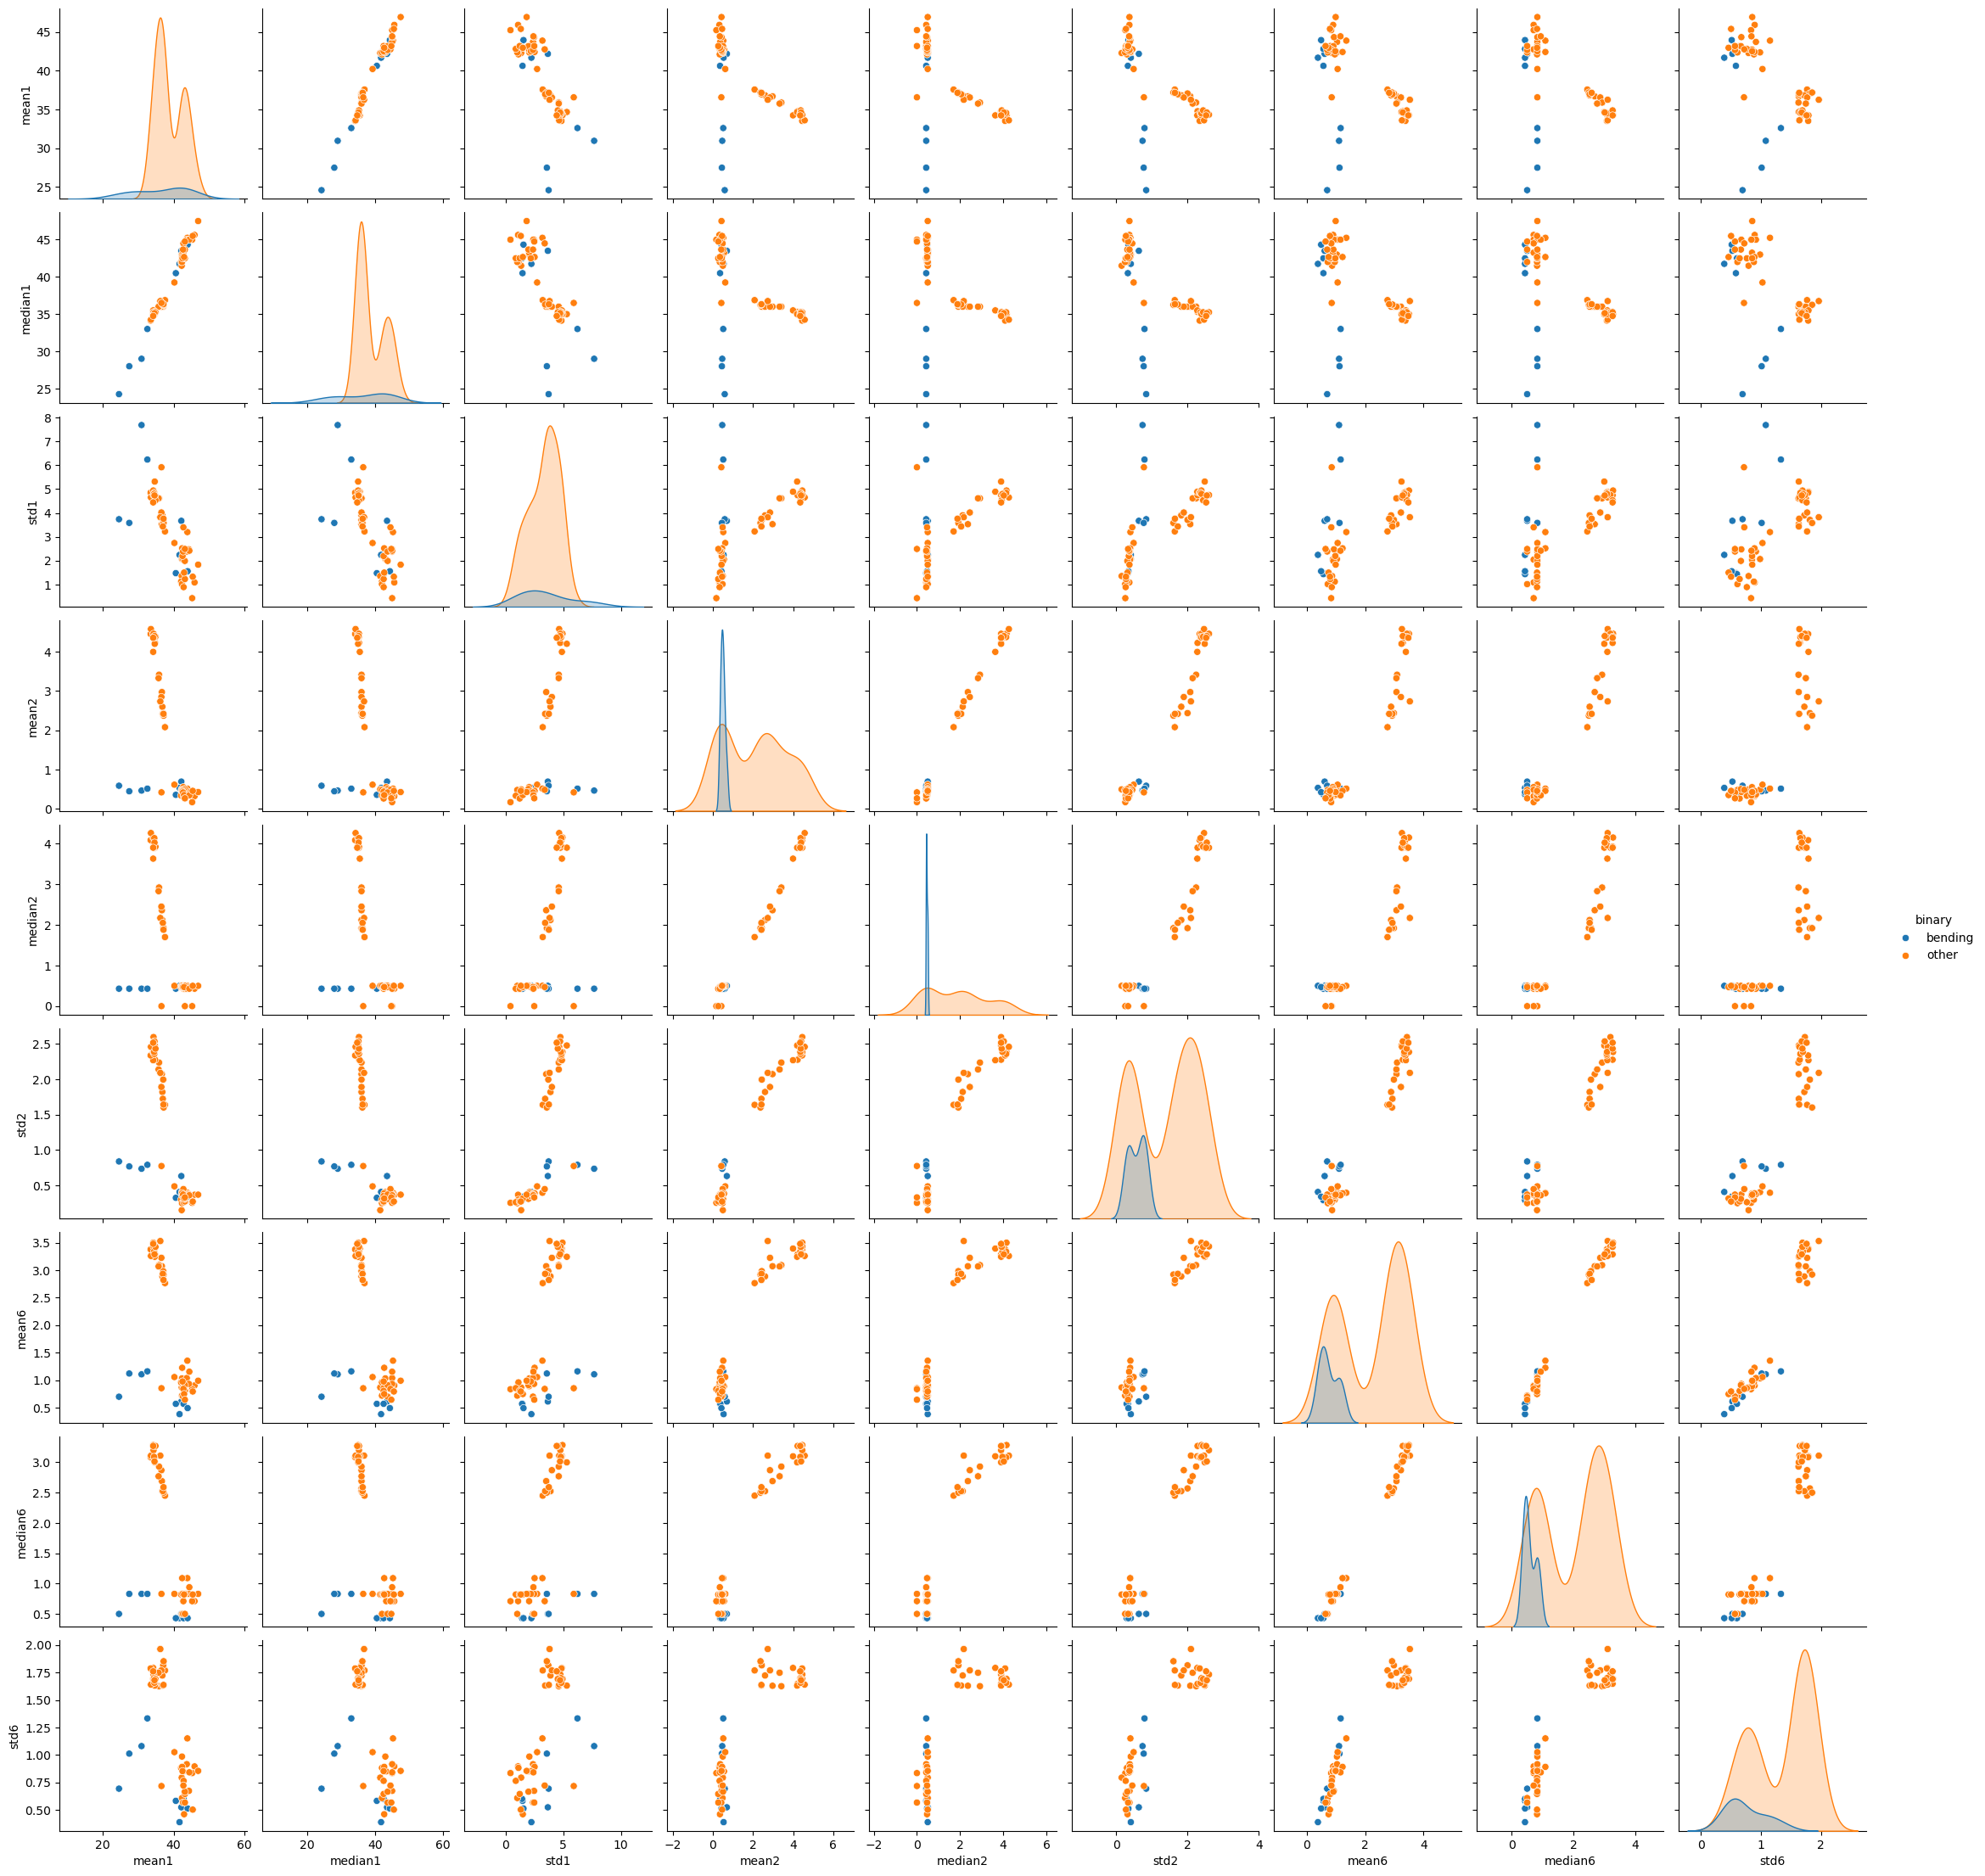

In [16]:
#plan: take training split identified previously, and create activity tables that find the time series data 
#(mean,median,std only as identified in last HW for all time series first) for only 1,2,and 6 time series 
#then merge into another larger table with all the activities

#create a function to avoid errors in reproducibility 

def featex(specific_activity): 
    #extracting mean,median, and std only for each dataset, for each timeseries 
    extracted_feat = []
    for dataset in specific_activity: 
        instancerow = []
        for eachtimeseries in [dataset.columns[1],dataset.columns[2],dataset.columns[6]]: 
            specific_timeseries = dataset[eachtimeseries]
            instancerow.append(specific_timeseries.mean())
            instancerow.append(specific_timeseries.median())
            instancerow.append(specific_timeseries.std())
        extracted_feat.append(instancerow)
    return extracted_feat 

columnname = []
for i in [1,2,6]:
    columnname += [f"mean{i}",f"median{i}",f"std{i}"]

#make actvitiy tables with 1,2,6 mean,median,std data, and label activity column for binary classification
bending1_traintbl = pd.DataFrame(featex(bending1_train),columns = columnname)
bending1_traintbl["activity"] = "bending"

bending2_traintbl = pd.DataFrame(featex(bending2_train),columns = columnname)
bending2_traintbl["activity"] = "bending"

cycling_traintbl = pd.DataFrame(featex(cycling_train),columns=columnname)
cycling_traintbl["activity"] = "other"

lying_traintbl = pd.DataFrame(featex(lying_train),columns=columnname)
lying_traintbl["activity"] = "other"

sitting_traintbl = pd.DataFrame(featex(sitting_train),columns=columnname)
sitting_traintbl["activity"] = "other"

standing_traintbl = pd.DataFrame(featex(standing_train),columns=columnname)
standing_traintbl["activity"] = "other"

walking_traintbl = pd.DataFrame(featex(walking_train),columns=columnname)
walking_traintbl["activity"] = "other"

#rejoining all activities 
trainingtbl = pd.concat([bending1_traintbl, bending2_traintbl, cycling_traintbl, lying_traintbl,sitting_traintbl, standing_traintbl, walking_traintbl],ignore_index = True) 
trainingtbl["binary"] = trainingtbl["activity"]

#plotting (9by9 pairplot) 
variables = ["mean1","median1","std1", "mean2","median2","std2","mean6","median6","std6"]

sea.pairplot(data = trainingtbl, vars = variables, hue = "binary", diag_kind = "kde") 
plt.show()


#### ii. Splitted Plots

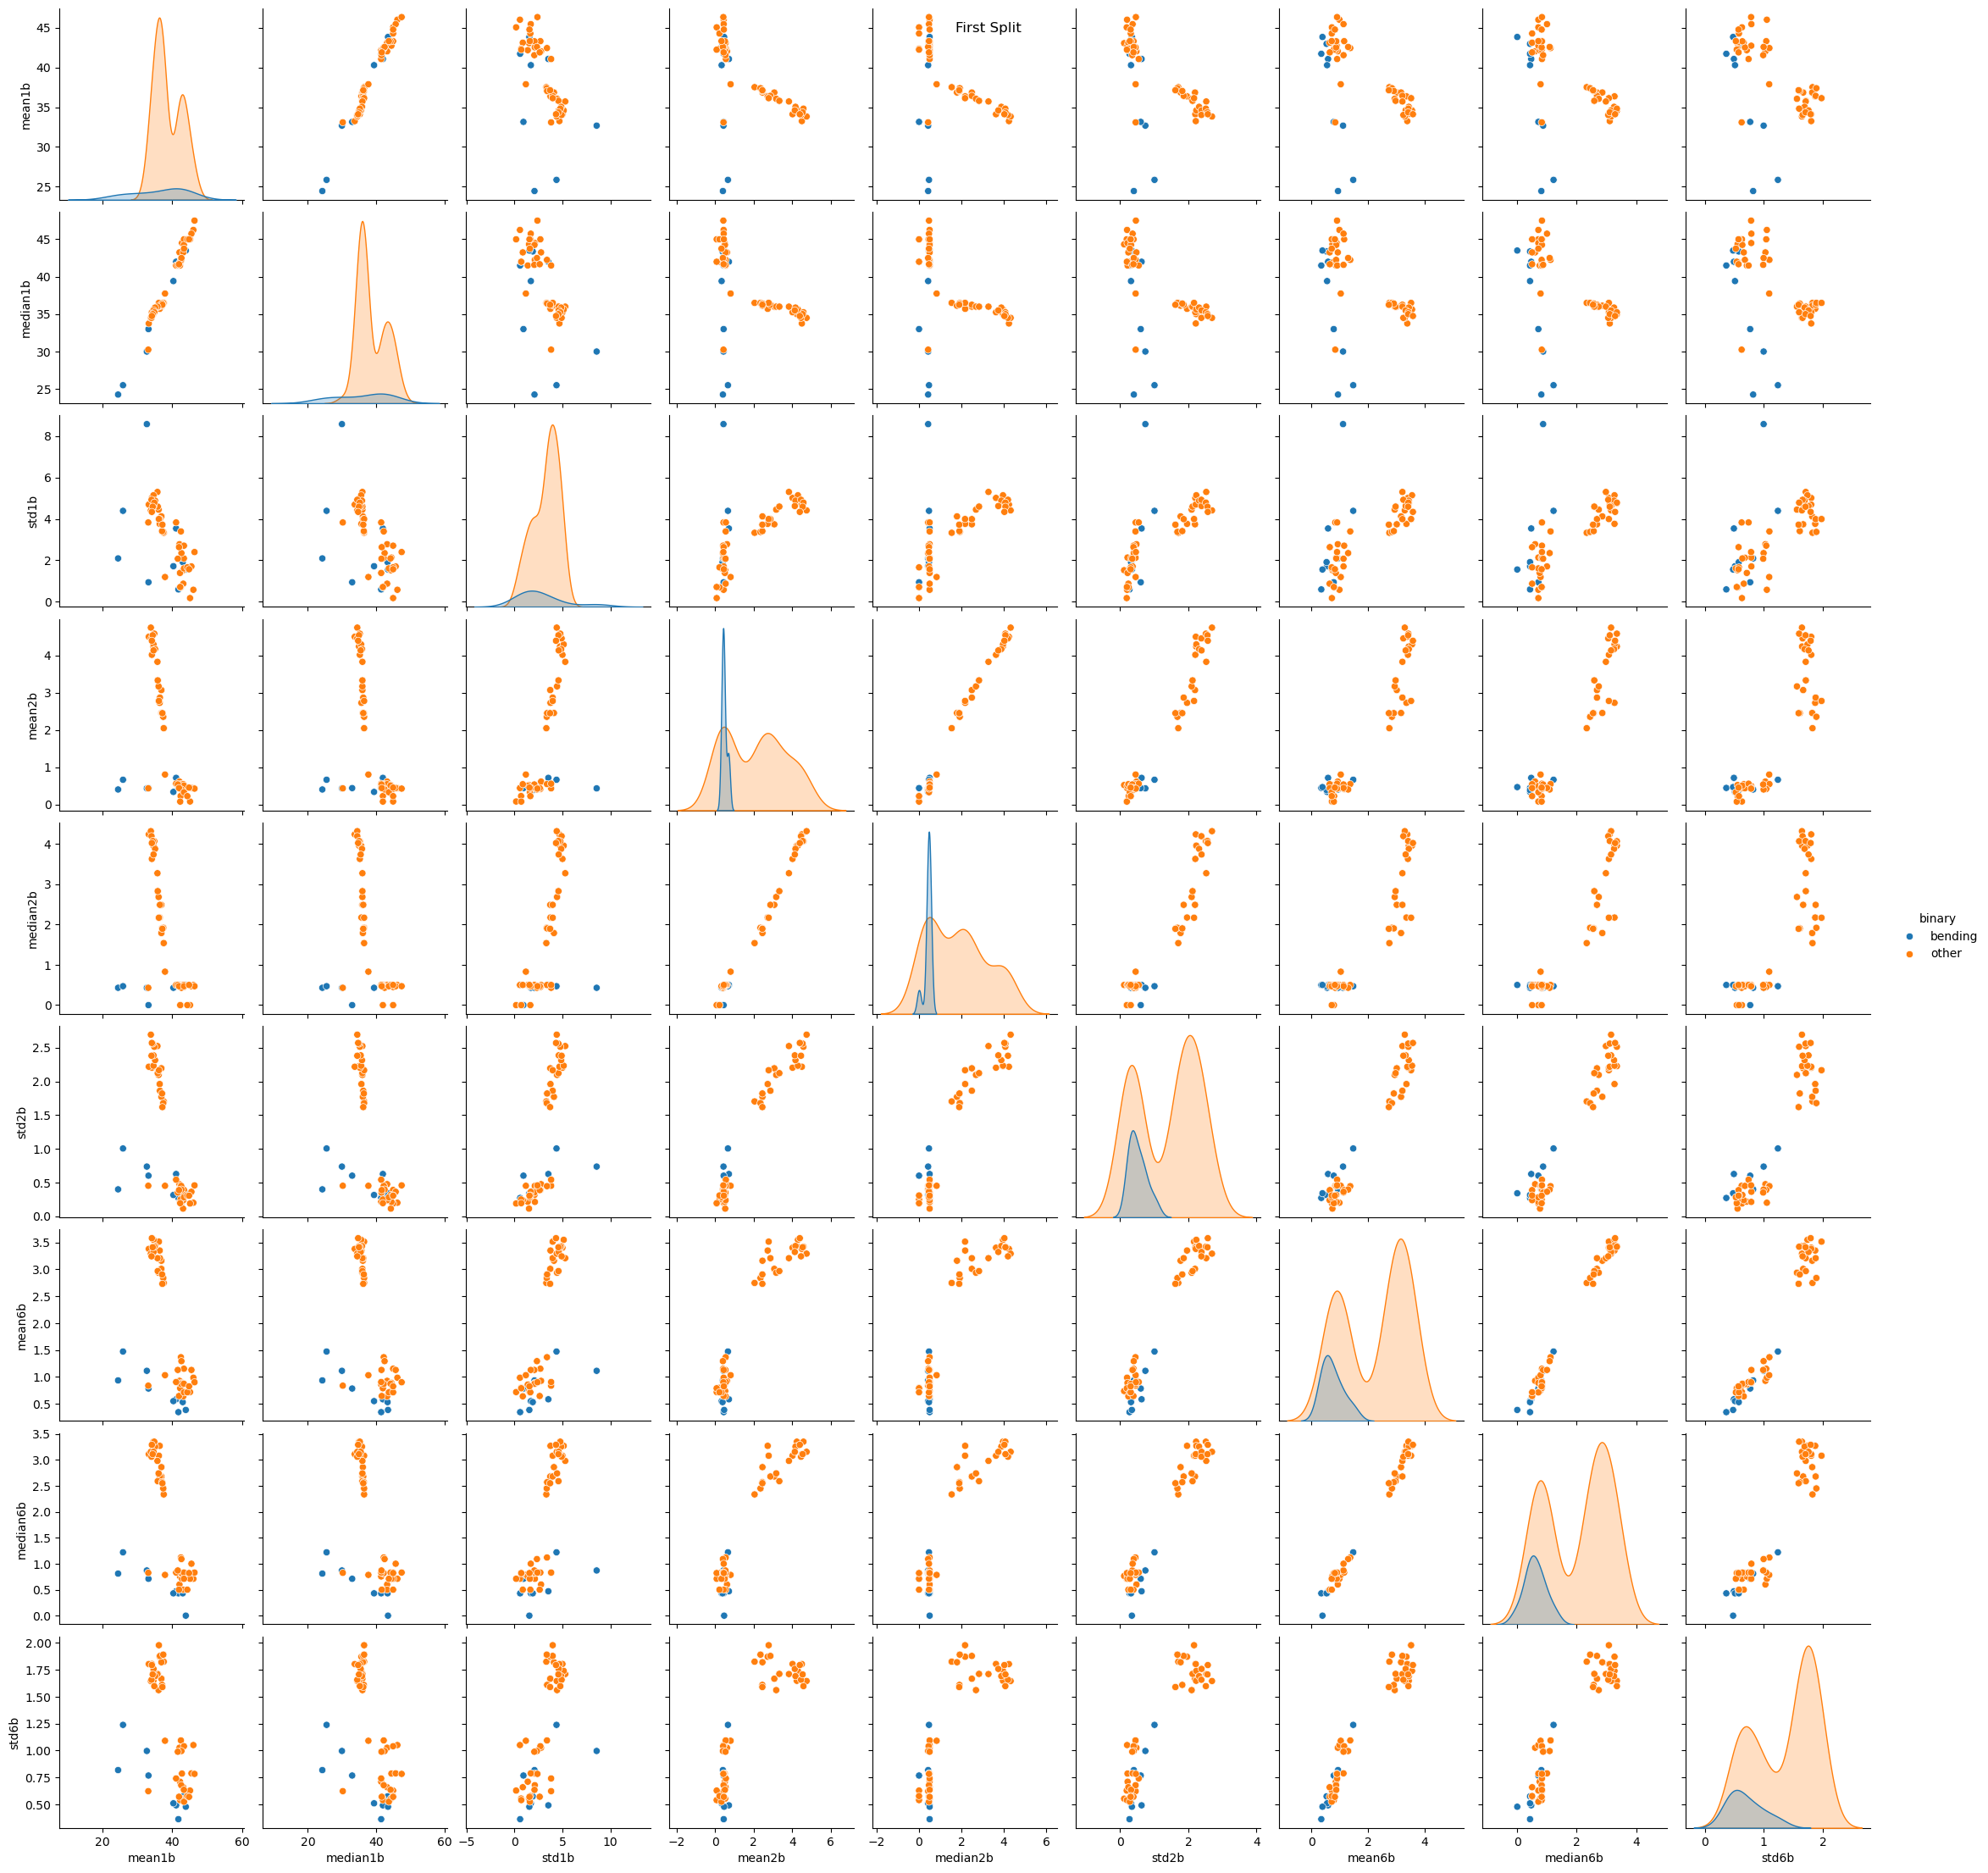

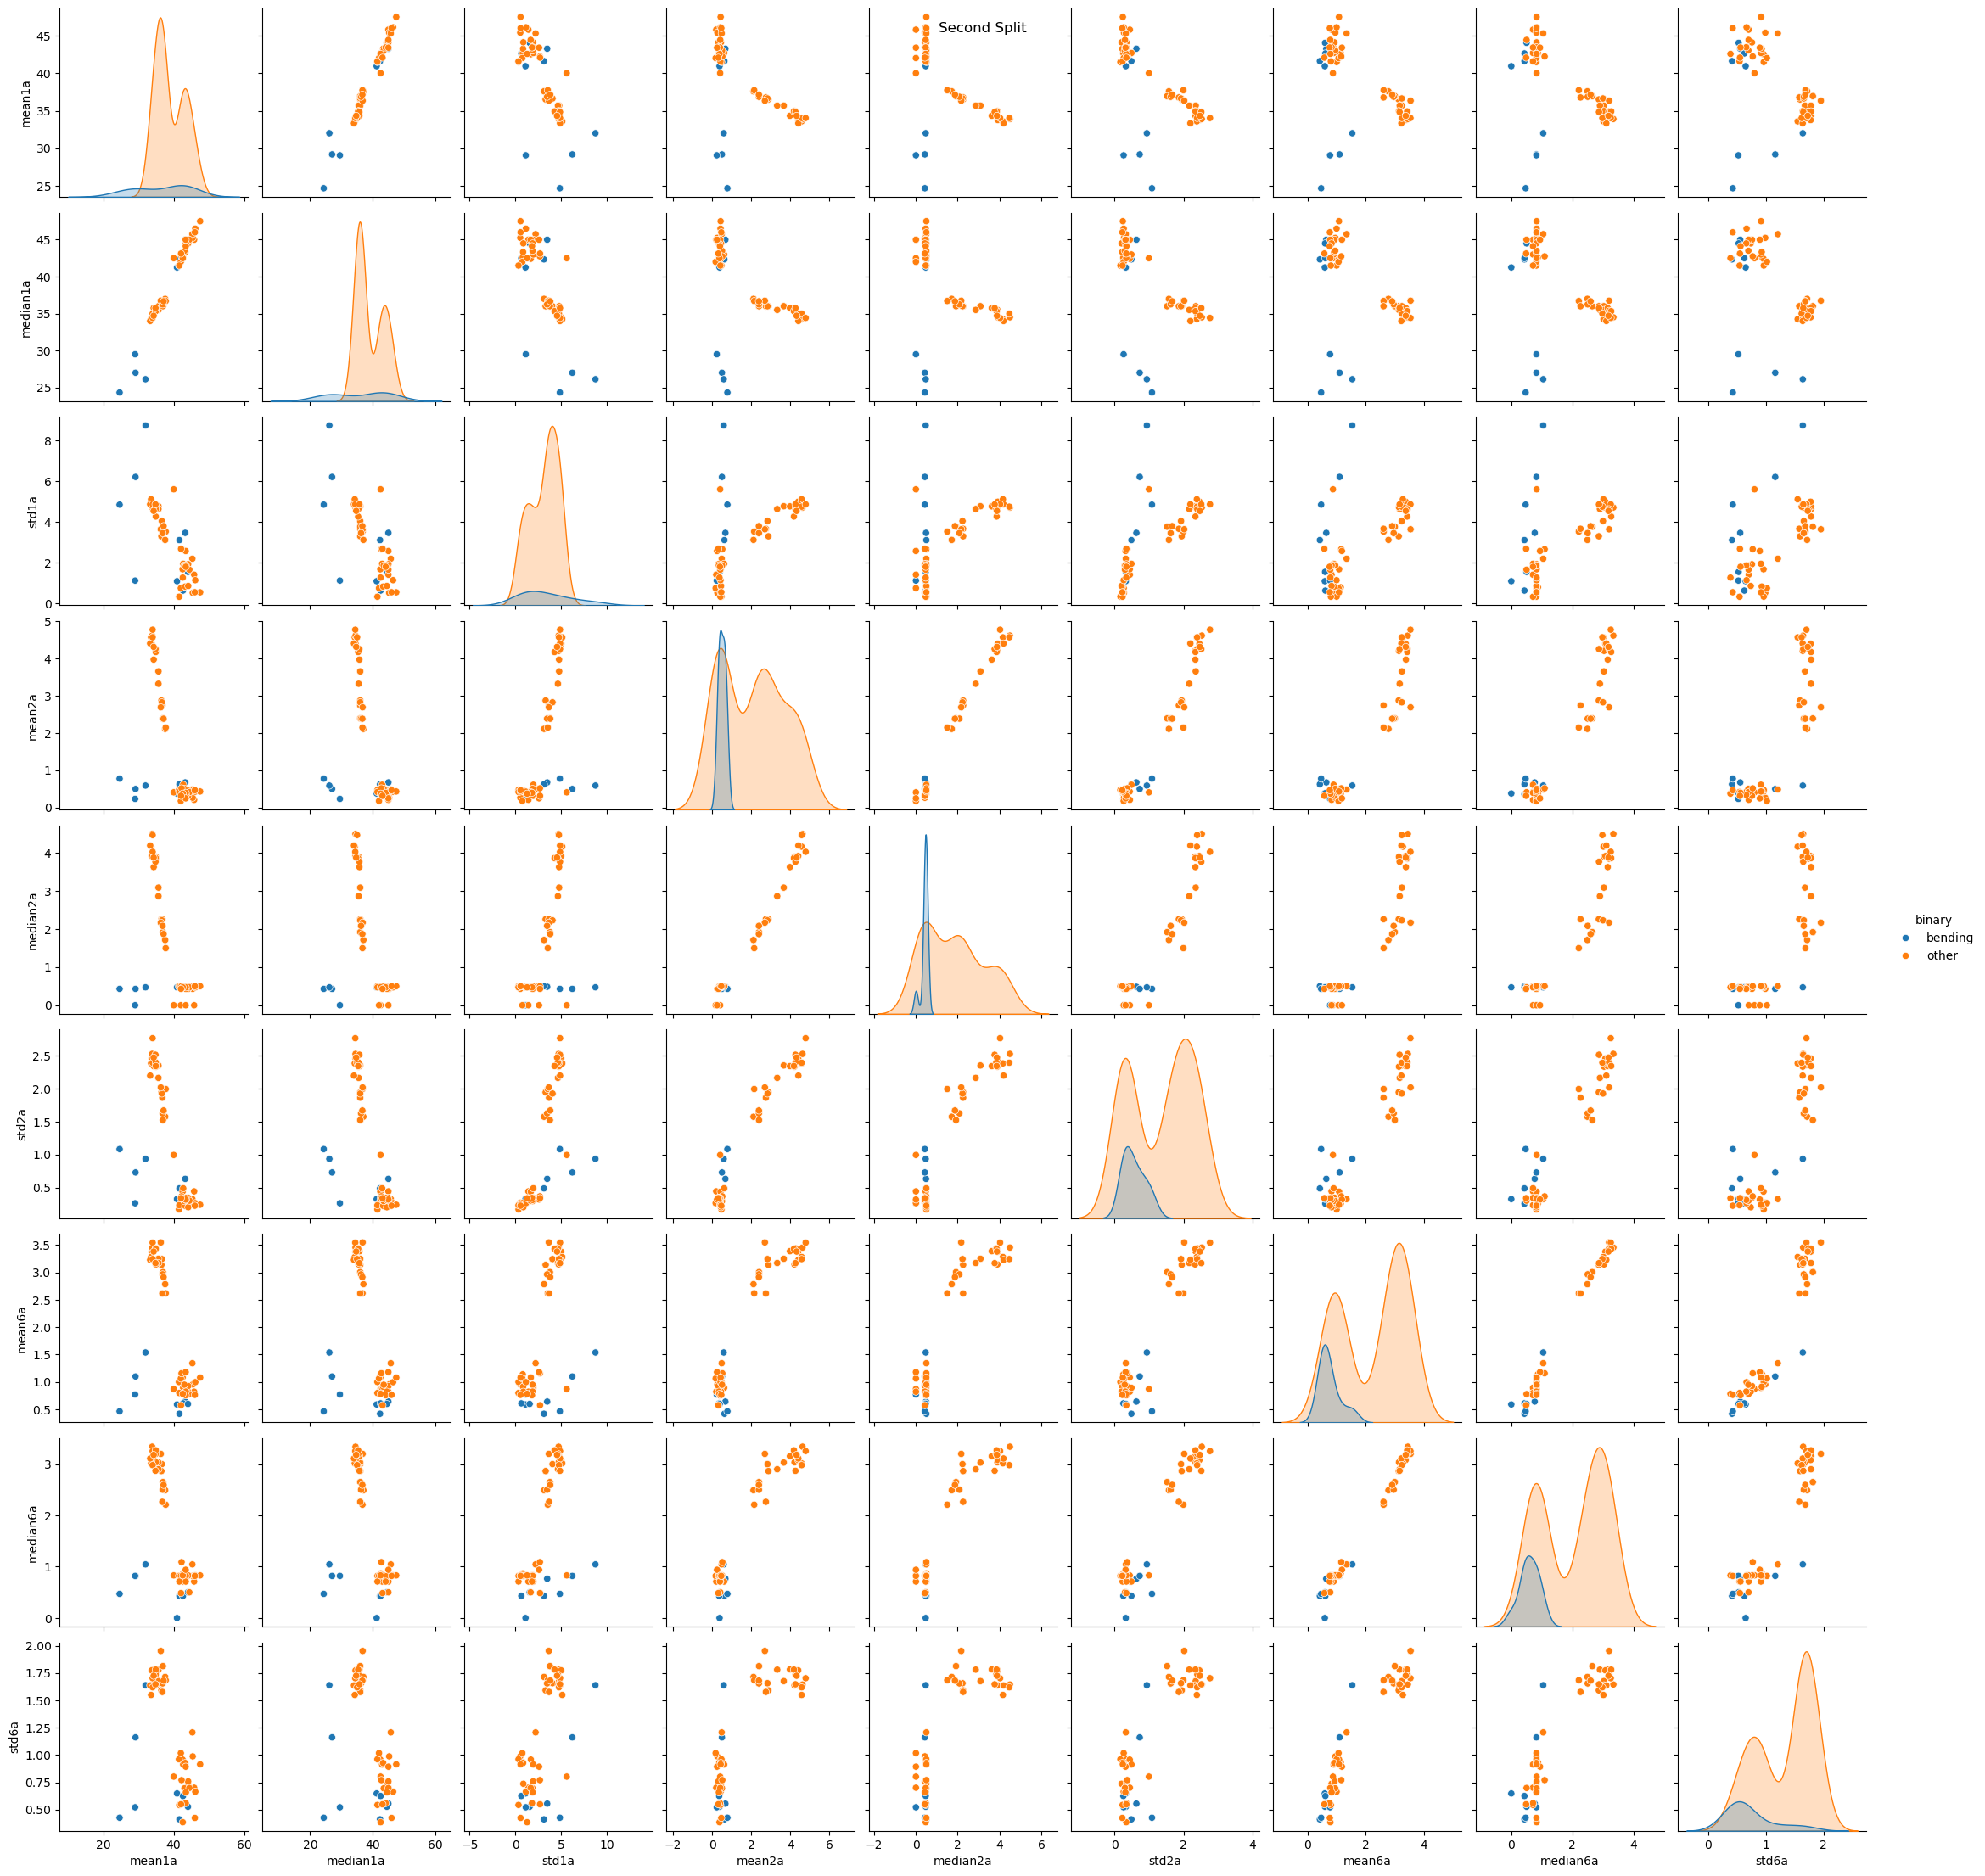

In [17]:
#redo the function to find middle index and split each training dataset into two 
def featex_splitted(specific_activity): 
    #extracting mean,median, and std only for each dataset, for each timeseries 
    extracted_feat = []
    for dataset in specific_activity: 
        instancerow = []
        for eachtimeseries in [dataset.columns[1],dataset.columns[2],dataset.columns[6]]: 
            specific_timeseries = dataset[eachtimeseries]
            midind = len(specific_timeseries) // 2 

            #half a 
            parta = specific_timeseries[:midind]
            instancerow.append(parta.mean())
            instancerow.append(parta.median())
            instancerow.append(parta.std())

            #half b 
            partb = specific_timeseries[midind:]
            instancerow.append(partb.mean())
            instancerow.append(partb.median())
            instancerow.append(partb.std())
            
        extracted_feat.append(instancerow)
    return extracted_feat 

columnname_splitted = []
for i in [1,2,6]:
    columnname_splitted += [f"mean{i}a",f"median{i}a",f"std{i}a",f"mean{i}b", f"median{i}b",f"std{i}b"]

#make actvitiy tables with 1,2,6 mean,median,std data, and label activity column for binary classification
bending1_traintblsp = pd.DataFrame(featex_splitted(bending1_train),columns = columnname_splitted)
bending1_traintblsp["activity"] = "bending"

bending2_traintblsp = pd.DataFrame(featex_splitted(bending2_train),columns = columnname_splitted)
bending2_traintblsp["activity"] = "bending"

cycling_traintblsp = pd.DataFrame(featex_splitted(cycling_train),columns=columnname_splitted)
cycling_traintblsp["activity"] = "other"

lying_traintblsp = pd.DataFrame(featex_splitted(lying_train),columns=columnname_splitted)
lying_traintblsp["activity"] = "other"

sitting_traintblsp = pd.DataFrame(featex_splitted(sitting_train),columns=columnname_splitted)
sitting_traintblsp["activity"] = "other"

standing_traintblsp = pd.DataFrame(featex_splitted(standing_train),columns=columnname_splitted)
standing_traintblsp["activity"] = "other"

walking_traintblsp = pd.DataFrame(featex_splitted(walking_train),columns=columnname_splitted)
walking_traintblsp["activity"] = "other"

#large table
trainingtblsp = pd.concat([bending1_traintblsp, bending2_traintblsp, cycling_traintblsp, lying_traintblsp,sitting_traintblsp, standing_traintblsp, walking_traintblsp],ignore_index = True) 
trainingtblsp["binary"] = trainingtblsp["activity"]

#plotting 
variablesp = ["mean1b","median1b","std1b","mean2b", "median2b", "std2b","mean6b","median6b","std6b"]
sea.pairplot(data = trainingtblsp, vars = variablesp, hue = "binary", diag_kind = "kde") 
plt.suptitle("First Split")
plt.show()


variablesp2 = ["mean1a","median1a","std1a","mean2a", "median2a", "std2a","mean6a","median6a","std6a"]
sea.pairplot(data = trainingtblsp, vars = variablesp2, hue = "binary", diag_kind = "kde")
plt.suptitle("Second Split")
plt.show()

Comment: There does not seem to be much of a difference between the two 9x9 pairplots above.

## 4. Time-Series Segmentation

To capture temporal structure in the signals, each of the six time series is divided into:

`l ∈ {1, 2, …, 20}` equal-length segments.

For each segmentation level:
- Compute the same statistical features (min, max, mean, etc.)
- Construct an expanded feature matrix
- Keep the number of instances constant while increasing feature dimensionality


In [20]:
#note: using sklearn 

#function for feature creation
def featexl(specific_activity,l): 
    extracted_feat = []
    
    for dataset in specific_activity: 
        instancerow = []

        for timeseriescolumn in dataset.columns[1:7]:
            timeseries = dataset[timeseriescolumn] 
            split_factor = len(timeseries) // l

            for j in range(l): #ensures equal split if length not divisible equally by l 
                start = j*split_factor 
                if j < l-1:
                    end = (j+1) * split_factor 
                else:
                    end = len(timeseries)

                split = timeseries[start:end] 

                instancerow.append(split.mean())
                instancerow.append(split.median())
                instancerow.append(split.std())
                instancerow.append(split.min())
                instancerow.append(split.max())
                instancerow.append(np.percentile(split,25))
                instancerow.append(np.percentile(split,75))

        extracted_feat.append(instancerow) 
        
    return extracted_feat 

#function for column name 
def columnlabel(l):
    col = []
    for timeseri in range(1,7):
        for parts in range(1,l+1): 
            for stat in ["min", "max", "mean", "median", "std", "1st_quart", "3rd_quart"]:
                col.append(f"{stat}{timeseri}_{parts}")

    return col 


l_val = range(1,21) 

training_tables_for_all_l = {} 

for l in l_val: 

    #go through each activity 
    bending1 = pd.DataFrame(featexl(bending1_train,l), columns = columnlabel(l))
    bending1["activity"] = "bending" 

    bending2 = pd.DataFrame(featexl(bending2_train,l), columns = columnlabel(l))
    bending2["activity"] = "bending"

    cycling = pd.DataFrame(featexl(cycling_train,l), columns = columnlabel(l))
    cycling["activity"] = "other"
    
    lying = pd.DataFrame(featexl(lying_train,l), columns = columnlabel(l))
    lying["activity"] = "other"
    
    sitting = pd.DataFrame(featexl(sitting_train,l), columns = columnlabel(l))
    sitting["activity"] = "other"
    
    standing = pd.DataFrame(featexl(standing_train,l), columns = columnlabel(l))
    standing["activity"] = "other"
    
    walking = pd.DataFrame(featexl(walking_train,l), columns = columnlabel(l)) 
    walking["activity"] = "other"

    #combining 
    training_tblfull = pd.concat([bending1,bending2,cycling,lying,sitting,standing,walking]) 

    #labeling for binary 0 or 1, where bending = 1, other = 0
    #creating binary table, assigning all as 0 but only updating 1 when the table is bending data
    training_tblfull["binary"] = 0
    training_tblfull.loc[training_tblfull["activity"] == "bending","binary"] = 1 

    training_tables_for_all_l[l] = training_tblfull 

## 5. Logistic Regression with p-Value-Based Feature Selection

For each segmentation level:

1. Fit logistic regression  
2. Calculate p-values for all coefficients  
3. Remove statistically insignificant predictors  
4. Refit the logistic regression model  
5. Evaluate using stratified 5-fold cross-validation  

### Correct cross-validation protocol
Feature selection must occur **inside each training fold**.  
Performing feature selection before CV introduces leakage and overestimates model performance.


In [21]:
#perform linear regression RFE 

rferes = {} #storing RFE results
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 92)
logmod = LogisticRegression(penalty = None, max_iter = 5000) 

for l,table in training_tables_for_all_l.items():

    #split into X and y 
    X = table.drop(columns = ["activity","binary"]) 
    y = table["binary"] 

    #capping p 

    if X.shape[1] >= len(X):
        X = X.iloc[:, :len(X)-1]

    #RFE setting up
    RFEfeatselection = RFECV(estimator=logmod, step=1, cv=cv, scoring="accuracy", n_jobs=-1) #leaving n_jobs and accuracy score in as

    #fitting RFE 
    RFEfeatselection.fit(X, y)

    #accuracy score using .score()
    train_acc = RFEfeatselection.score(X, y)
    
    #storing results
    rferes[l] = {"p_best": RFEfeatselection.n_features_, "F1 Score": f1_score(y, RFEfeatselection.predict(X)), "ROC_AUC Score": roc_auc_score(y, RFEfeatselection.predict_proba(X)[:,1]), "Training Accuracy": train_acc}
    

    #summary table
lsplit = []
for l in rferes:
    lsplit.append([
        l,
        rferes[l]["p_best"],
        rferes[l]["F1 Score"],
        rferes[l]["ROC_AUC Score"],
        rferes[l]["Training Accuracy"]
        ])

summarytbl = pd.DataFrame(lsplit, columns=["l", "p", "F1", "ROC_AUC","Training Accuracy"])

summarytbl

,l,p,F1,ROC_AUC,Training Accuracy
0,1,3,1.000000,1.000000,1.000000
1,2,11,1.000000,1.000000,1.000000
2,3,4,1.000000,1.000000,1.000000
3,4,8,1.000000,1.000000,1.000000
4,5,27,1.000000,1.000000,1.000000
5,6,2,0.333333,0.890741,0.884058
6,7,2,0.500000,0.851852,0.913043
7,8,2,0.533333,0.935185,0.898551
8,9,1,0.000000,0.737963,0.869565
9,10,2,0.533333,0.949074,0.898551


EXPLANATION: 

The RFE method was used rather than refitting or glm in R. Based on the table above, there are several (l,p) with tied F1 and ROC_AUC so we pick the one with the lowest of l and p values. This is (l,p) = (1,3). The right way to perform cross validation is to perform the selection of features within each fold of cross validation process. The wrong way would be to select features on the whole dataset but then only do cross validation on a reduced set with a smaller amount of features that we selected because of data leakage issues as discussed in lecture. 

I used StratifiedKFold to avoid class imbalance. 

## 6. Binary Classification Evaluation


In [43]:
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,auc, accuracy_score

import scipy.stats as sm

best_l = 1
best_p = 3

besttable = training_tables_for_all_l[best_l]

#splitting X and y 
X = besttable.drop(columns = ["activity","binary"])
y = besttable["binary"].astype(int)

#refitting logistic regression 
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 11) 
logmod = LogisticRegression(penalty = None, max_iter= 5000)
RFEfeatselection = RFECV(estimator=logmod, step=1, cv=cv, scoring="accuracy", n_jobs=-1)
RFEfeatselection.fit(X, y)
    
#need to setup RFE to find best p values
logmod = LogisticRegression(penalty=None, max_iter=5000)


RFEfeatselections = RFECV(estimator = logmod,step = 1, cv = cv, scoring = "accuracy", n_jobs = -1) 
RFEfeatselections.fit(X,y)

#finding selected features
selectedfeatures = X.columns[RFEfeatselection.support_]
X_best = X[selectedfeatures]

#applying selected features to refit logistic regression
predictmod = LogisticRegression(penalty = None, max_iter = 5000)
predictmod.fit(X_best,y)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


### 6.1 Training confusion matrix
Displays misclassification structure on the training data.

In [44]:
#confusion 
y_pred = predictmod.predict(X_best).astype(int)
conf = confusion_matrix(y,y_pred) 
print(conf)

[[60  0]
 [ 0  9]]


### 6.2 ROC curve and AUC
Evaluates classifier performance across thresholds.

AUC score is 1.0
F1 score is 1.0
accuracy score is 1.0


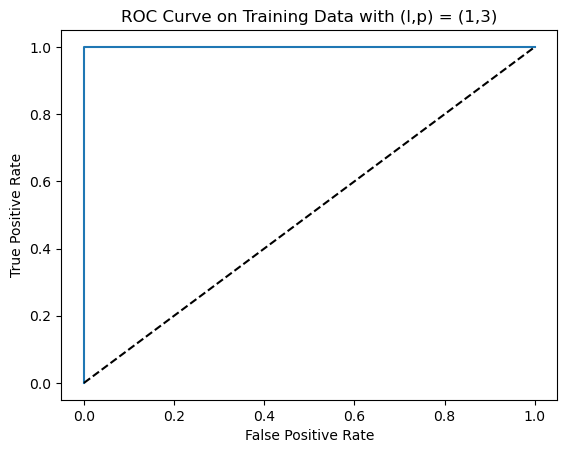

In [45]:
#ROC/AUC 
y_pred_probability = predictmod.predict_proba(X_best)[:,1]
f1_train = f1_score(y, y_pred)
fpr,tpr, _ = roc_curve(y,y_pred_probability)
auc_v = roc_auc_score(y,y_pred_probability) 
accuracy_train = accuracy_score(y,y_pred)
print("AUC score is" , auc_v)
print("F1 score is", f1_train)
print("accuracy score is" , accuracy_train)

#plotting the ROC curve: 
plt.plot(fpr, tpr, label = auc_v) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') #random classifier line
plt.title("ROC Curve on Training Data with (l,p) = (1,3)") 
plt.show()

### 6.3 Coefficients and statistical significance
List the selected features and their logistic regression coefficients with corresponding p-values.

In [24]:
#logistic regression parameters and p-values 
intercept = predictmod.intercept_[0]
coefficients = predictmod.coef_[0] 

#note that the following code comes from an online github help page 
decision = predictmod.decision_function(X_best)
denom = (2.0 * (1.0 + np.cosh(decision)))
denom = np.tile(denom, (X_best.shape[1], 1)).T

F_ij = np.dot((X_best / denom).T, X_best)
eps = 1e-4
F_ij += np.eye(F_ij.shape[0]) * eps
Cramer_Rao = np.linalg.inv(F_ij)
sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
z_scores = predictmod.coef_[0] / sigma_estimates
p_values = [sm.norm.sf(abs(z)) * 2 for z in z_scores]
        
#summary table 
summarytbl1 = pd.DataFrame({"Feature": X_best.columns, "b_i": coefficients, "StdErr": sigma_estimates, "z": z_scores, "p-value": p_values})
summarytbl1

,Feature,b_i,StdErr,z,p-value
0,min1_1,-1.937194,9.219246,-0.210125,0.833570
1,std5_1,1.442135,12.622559,0.114251,0.909039
2,1st_quart5_1,1.320060,24.080061,0.054820,0.956282


### 6.4 Test set accuracy
Evaluate on held-out test data using the same segmentation level and selected features.  
Compare test accuracy to the cross-validation result.


The confusion matrix is:  [[15  0]
 [ 3  1]]
The F1 score is:  0.4
The ROC AUC score is:  0.9333333333333333
The test accuracy score is:  0.8421052631578947


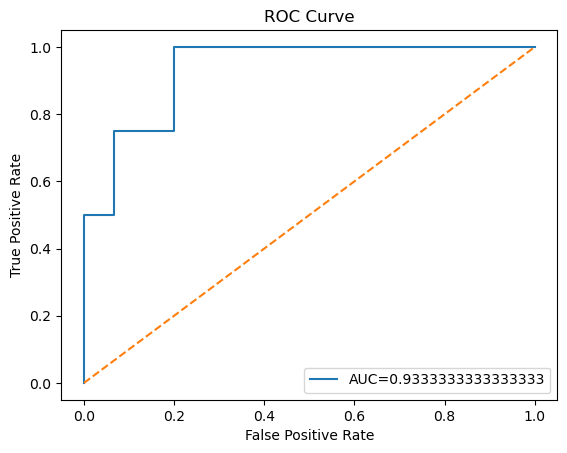

In [38]:
#creating a test set similar to how training was created 

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,auc, accuracy_score

best_l = 1 

bending1_test_tbl = pd.DataFrame(featexl(bending1_test, best_l), columns=columnlabel(best_l))
bending1_test_tbl["activity"] = "bending"

bending2_test_tbl = pd.DataFrame(featexl(bending2_test, best_l), columns=columnlabel(best_l))
bending2_test_tbl["activity"] = "bending"

cycling_test_tbl = pd.DataFrame(featexl(cycling_test, best_l), columns=columnlabel(best_l))
cycling_test_tbl["activity"] = "other"

lying_test_tbl = pd.DataFrame(featexl(lying_test, best_l), columns=columnlabel(best_l))
lying_test_tbl["activity"] = "other"

sitting_test_tbl = pd.DataFrame(featexl(sitting_test, best_l), columns=columnlabel(best_l))
sitting_test_tbl["activity"] = "other"

standing_test_tbl = pd.DataFrame(featexl(standing_test, best_l), columns=columnlabel(best_l))
standing_test_tbl["activity"] = "other"

walking_test_tbl = pd.DataFrame(featexl(walking_test, best_l), columns=columnlabel(best_l))
walking_test_tbl["activity"] = "other"

test_tbl_full = pd.concat([
    bending1_test_tbl, bending2_test_tbl, cycling_test_tbl,
    lying_test_tbl, sitting_test_tbl, standing_test_tbl, walking_test_tbl
    ])

test_tbl_full["binary"] = 0
test_tbl_full.loc[test_tbl_full["activity"] == "bending", "binary"] = 1

#taking the best feature from 2aiii (1,3) for test 

X_test = test_tbl_full[selectedfeatures]
y_test = test_tbl_full["binary"]

#evaluating model from 2iv on test data
y_test_pred = predictmod.predict(X_test)
y_test_probability = predictmod.predict_proba(X_test)[:,1]

#confusion matrix and various scores 
conftest = confusion_matrix(y_test,y_test_pred) 
f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_probability)
accuracy_test = accuracy_score(y_test,y_test_pred) 
print("The confusion matrix is: ", conftest) 
print("The F1 score is: ", f1_test)
print("The ROC AUC score is: ",auc_test)
print("The test accuracy score is: ", accuracy_test)

#ROC curve 

fpr, tpr, _ = roc_curve(y_test, y_test_probability)
roc_auc_val = auc(fpr, tpr) 

plt.plot(fpr, tpr, label="AUC=" + str(roc_auc_val))
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Comment on the accuracy: the "accuracy" method was used for cv for this test data and the train data in 2iv. The accuracy for the train and test differ with the train accuracy being 1.0 and test accuracy being 0.84. This makes sense because the test data is new data for the model, whereas the train accuracy was based on the train dataset, and the training data was used to train the model so of course it would have an accuracy score of 1.0. Note the test data used (l,p) of (1,3) features. 

#### Separation

Given that my training accuracy scores are 1.0 which are the highest they can be. This might suggest overfitting of the data, as it is usually a red flag that the accuracy is the highest possible number. Also, because the test accuracy score decreases and the F1 score decreases in the test data quite sharply compared to the train accuracy and f1 score, this suggests that the model was overfitted. So yes, they seem to be well seperated, but almost too well seperated. 

####  Imbalance

Yes, I see some class imbalances between positive and negative class (15 vs 1) in the test data, and in the training data (60 vs 9). Thus I will have to build a logreg model based on case-control sampling. 

The confusion matrix is:  [[15  0]
 [ 3  1]]
The F1 score is:  0.4
The ROC AUC score is:  0.9166666666666666
The test accuracy score is:  0.8421052631578947


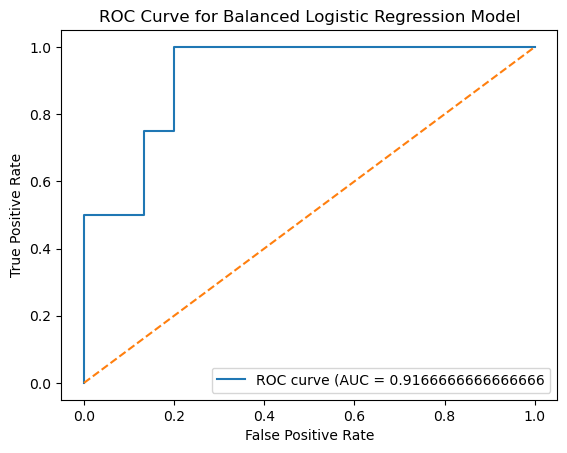

In [31]:
#I have decided to use the imbalanced-learn package and use RandomUnderSampler in order to balance the training data.

!pip install -U imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,auc, accuracy_score


under = RandomUnderSampler(random_state = 31) 
X_balanced, y_balanced = under.fit_resample(X_best,y) 

#training on balanced dataset 
logbal = LogisticRegression(penalty=None, max_iter=5000)
logbal.fit(X_balanced, y_balanced)

#evaluating model on test set 
y_test_pred_bal = logbal.predict(X_test) 
y_test_prob_bal = logbal.predict_proba(X_test)[:,1] 

#accuracy metrics 
confbal = confusion_matrix(y_test, y_test_pred_bal)
f1bal = f1_score(y_test, y_test_pred_bal)
aucbal = roc_auc_score(y_test, y_test_prob_bal)
accbal = accuracy_score(y_test, y_test_pred_bal)
print("The confusion matrix is: ", confbal) 
print("The F1 score is: ", f1bal)
print("The ROC AUC score is: ",aucbal)
print("The test accuracy score is: ", accbal)

#ROC/AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob_bal)
roc_aucb = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = ' + str(roc_aucb))
plt.plot([0, 1], [0, 1],"--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Balanced Logistic Regression Model')
plt.legend()
plt.show()

Comment: 
The accuracy scores for the test data were either the same or slightly lower when undersampling, as shown by the accuracy results reported in the line above. 

## 7. L1-Regularized Logistic Regression
### 7.1 Motivation
L1 regularization provides:
- Automatic variable selection  
- Stability when classes are nearly linearly separable  
- A sparse and interpretable model  

### 7.2 Tuning segmentation level and regularization strength
For each segmentation level `l`, perform cross-validation over values of `λ` (or inverse `C`) and select the best-performing combination.


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
#C = 1/lambda, so must test different C values 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

Cs = np.logspace(-10, 10, 12)

l_results = []

for l, table in training_tables_for_all_l.items():
    
    X = table.drop(columns=["activity", "binary"])
    y = table["binary"]

    #standardizing the dataset according to the footnote
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    logmodcv = LogisticRegressionCV(penalty="l1", solver="liblinear", Cs=Cs, cv=cv, scoring="accuracy", refit = True, max_iter=5000, n_jobs=-1)

    logmodcv.fit(X_scaled,y)
    cv_scores = logmodcv.scores_[1]
    bestCindex = logmodcv.C_[0] 

    #nonzero coeff 
    coeff = list(logmodcv.coef_[0]) 
    selectedfeat = []
    for i in range(len(coeff)):
        if coeff[i] != 0:
            selectedfeat.append(X.columns[i]) 

    p_num = len(selectedfeat)

    
    #applying on training data 
    y_pred = logmodcv.predict(X_scaled)
    y_probability = logmodcv.predict_proba(X_scaled)[:, 1]

    #calculating metrics
    confl1 = confusion_matrix(y,y_pred)
    acct = accuracy_score(y, y_pred)
    f1t = f1_score(y, y_pred)
    auct = roc_auc_score(y, y_probability)
    

    l_results.append({"l": l, "p": p_num, "Accuracy Score": acct,})

summarytbl = pd.DataFrame(l_results)
print(confl1, acct,f1t,auct)
summarytbl


[[60  0]
 [ 0  9]] 1.0 1.0 1.0


,l,p,Accuracy Score
0,1,6,1.0
1,2,10,1.0
2,3,39,1.0
3,4,44,1.0
4,5,51,1.0
5,6,65,1.0
6,7,68,1.0
7,8,67,1.0
8,9,77,1.0
9,10,110,1.0


###  7.3 Comparison to p-value-based selection
Summarize differences in accuracy, sparsity, coefficient stability, and implementation complexity.

The L1-penalized logistic regression seems to be better in performance as the accuracy score for all of the l's were 1.0, and for the logistic regression done in 2aiii, the the training accuracy score varied from 0.9-1.0. The L-1 penalized logistic regression also seems to be implemented easier because it doesnt require using a whole other algorithm in order to calculate p-values, as scikitlearn is unable to calculate p-values and needs another set of equations to be able to do so (like the website TA Narges had provided to us). The L-1 penalized logistic regression handles cross validation in the model itself, not requiring outside calculations like the p-values for the 2aii variable selection. 

## 8. Multiclass Activity Classification


### 8.1 Multinomial logistic regression with L1 penalty
Train a multinomial logistic regression model on all seven activities and evaluate:
- Cross-validation accuracy  
- Test accuracy  
- Feature sparsity  

In [28]:
l_val = range(1, 21)
training_tables_for_all_l_multiclass = {}

for l in l_val:
    
    bending1 = pd.DataFrame(featexl(bending1_train, l), columns=columnlabel(l))
    bending1["activity"] = "bending1"

    bending2 = pd.DataFrame(featexl(bending2_train, l), columns=columnlabel(l))
    bending2["activity"] = "bending2"

    cycling = pd.DataFrame(featexl(cycling_train, l), columns=columnlabel(l))
    cycling["activity"] = "cycling"

    lying = pd.DataFrame(featexl(lying_train, l), columns=columnlabel(l))
    lying["activity"] = "lying"

    sitting = pd.DataFrame(featexl(sitting_train, l), columns=columnlabel(l))
    sitting["activity"] = "sitting"

    standing = pd.DataFrame(featexl(standing_train, l), columns=columnlabel(l))
    standing["activity"] = "standing"

    walking = pd.DataFrame(featexl(walking_train, l), columns=columnlabel(l))
    walking["activity"] = "walking"

    training_tblfull = pd.concat([bending1, bending2, cycling, lying, sitting, standing, walking])

    training_tables_for_all_l_multiclass[l] = training_tblfull

    

In [29]:
test_tables_for_all_l_multiclass = {}

for l in l_val:
    
    bending1 = pd.DataFrame(featexl(bending1_test, l), columns=columnlabel(l))
    bending1["activity"] = "bending1"

    bending2 = pd.DataFrame(featexl(bending2_test, l), columns=columnlabel(l))
    bending2["activity"] = "bending2"

    cycling = pd.DataFrame(featexl(cycling_test, l), columns=columnlabel(l))
    cycling["activity"] = "cycling"

    lying = pd.DataFrame(featexl(lying_test, l), columns=columnlabel(l))
    lying["activity"] = "lying"

    sitting = pd.DataFrame(featexl(sitting_test, l), columns=columnlabel(l))
    sitting["activity"] = "sitting"

    standing = pd.DataFrame(featexl(standing_test, l), columns=columnlabel(l))
    standing["activity"] = "standing"

    walking = pd.DataFrame(featexl(walking_test, l), columns=columnlabel(l))
    walking["activity"] = "walking"

    test_tbl_full_multiclass = pd.concat([bending1, bending2, cycling, lying, sitting, standing, walking])

    test_tables_for_all_l_multiclass[l] = test_tbl_full_multiclass


### 8.2 Multiclass confusion matrix
Visualize classification performance and analyze:
- Well-separated activities  
- Frequently confused activity pairs  
- Similarity in postural classes  

In [32]:
#use "saga" solver and "multinomial" for multi_class in the LogRegCV function 

from sklearn.preprocessing import StandardScaler, label_binarize

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
Cs = np.logspace(-10, 10, 12)

l_results = []

for l, table in training_tables_for_all_l_multiclass.items():
    
    X = table.drop(columns=["activity"])
    y = table["activity"]

    # standardizing the dataset according to the footnote
    scaler = StandardScaler()
    X_scaledm = scaler.fit_transform(X)

    logmodcvmult = LogisticRegressionCV(penalty="l1", solver="saga", multi_class="multinomial", Cs=Cs, cv=cv, scoring="accuracy", refit=True, max_iter=5000, n_jobs=-1)
    #fitting data
    logmodcvmult.fit(X_scaledm, y)
    bestC = logmodcvmult.C_[0]
    
    # count number of nonzero coefficients across all classes
    abs_coeff = np.abs(logmodcvmult.coef_).max(axis=0)

    selectedfeat = []
    for i in range(min(len(abs_coeff), len(X.columns))):
        if abs_coeff[i] != 0:
            selectedfeat.append(X.columns[i])


    p_nummult = len(selectedfeat)
    
    #need to apply regression model on TEST data 
    test_table = test_tables_for_all_l_multiclass[l]
    X_test = test_table.drop(columns=["activity"])
    y_test = test_table["activity"]
    
    #need to align the columns because error was being thrown that columns did not match between test and train 
    X_test_aligned = X_test.reindex(columns=X.columns, fill_value=0)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_aligned), columns=X.columns)
    
    #predict
    y_test_pred = logmodcvmult.predict(X_test_scaled)


    #calculating confusion matrix and test error
    accm = accuracy_score(y_test, y_test_pred)
    test_error = 1 - accm

    l_results.append({"l": l,"p": p_nummult, "Test Error": test_error,})

summarytblm = pd.DataFrame(l_results)
summarytblm

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-

,l,p,Test Error
0,1,30,0.368421
1,2,45,0.473684
2,3,126,0.473684
3,4,168,0.473684
4,5,210,0.368421
5,6,252,0.368421
6,7,155,0.421053
7,8,336,0.473684
8,9,212,0.526316
9,10,420,0.473684


Reporting of Test Error (lowest error, best l) = 0.37 with a l = 1

### 8.3 Multiclass ROC curves (one-vs-rest)
If feasible, generate ROC curves for each class using one-vs-rest strategy.


Confusion Matrix
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


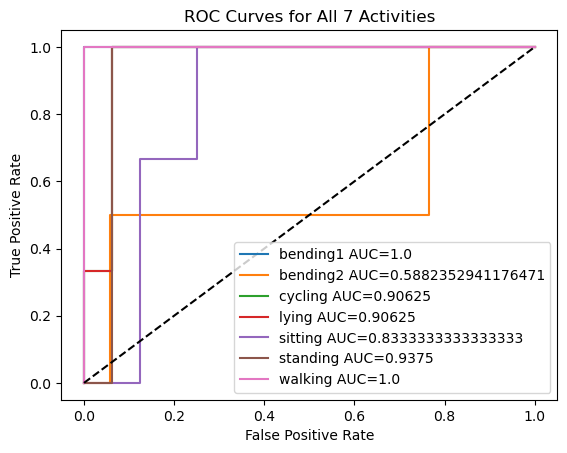

In [55]:
from sklearn.preprocessing import StandardScaler, label_binarize
#confusion matrix and roc auc score 

y = besttable["activity"]

classes = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
confm = confusion_matrix(y_test, y_test_pred, labels=classes)

print("Confusion Matrix")
print(confm)

#ROC/AUC 

y_score = logmodcvmult.predict_proba(X_test_scaled)

#one vs all comparison
y_test_bin = label_binarize(y_test, classes=classes)

# plot ROC curves for all classes on one figure 
plt.figure()

for i in range(7):
    fpr, tpr,_ = roc_curve(y_test_bin[:, i], y_score[:, i])
    rocn = auc(fpr, tpr)
    plt.step(fpr, tpr, label=classes[i] + " AUC=" + str(rocn))

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All 7 Activities")
plt.legend()
plt.show()

#I am aware the lying ROC looks a little weird, I have tried fixing it by ensuring the class order is the same for classes and logmodcvmult.classes_ and 
#ensuring the shape of y is the same for all however it has not fixed that issue. 

## 9. Naïve Bayes Models
### 9.1 Gaussian Naïve Bayes
Evaluate training and testing accuracy and interpret the confusion matrix.


Using l = 1, due to lowest test error from 2ci
Gaussian Test Error:  0.3157894736842105
[[0 0 0 0 2 0 0]
 [0 1 0 0 0 0 1]
 [0 0 3 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


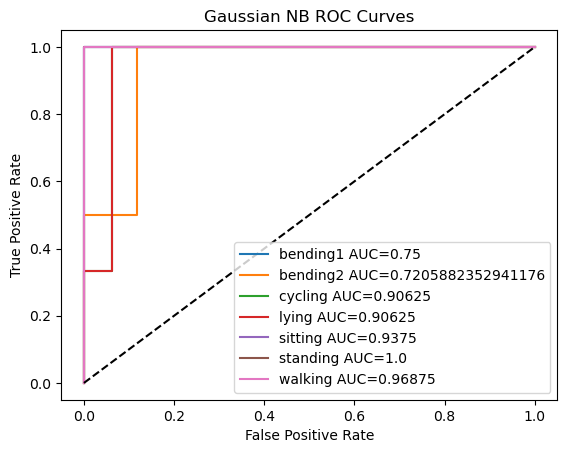

In [53]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler

best_l = 1  # from above

train_tbl = training_tables_for_all_l_multiclass[best_l]
X_train = train_tbl.drop(columns=["activity"])
y_train = train_tbl["activity"]

test_tbl  = test_tables_for_all_l_multiclass[best_l]
X_test  = test_tbl.drop(columns=["activity"])
y_test  = test_tbl["activity"]

classes = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]

print("Using l = 1, due to lowest test error from 2ci")

# Gaussian NB
scaler_gaus = StandardScaler()
X_train_g = scaler_gaus.fit_transform(X_train)
X_test_g  = scaler_gaus.transform(X_test)

gausnb = GaussianNB()
gausnb.fit(X_train_g, y_train)
y_pred_g = gausnb.predict(X_test_g)
acc_g = accuracy_score(y_test, y_pred_g)
test_error_g = 1-acc_g
print("Gaussian Test Error: ", test_error_g)

confusiongaus = confusion_matrix(y_test, y_pred_g, labels=classes)
print(confusiongaus)

#ROC/AUC
y_score_g = gausnb.predict_proba(X_test_g)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure()
for i in range(7):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_g[:, i])
    roc_aucz = auc(fpr, tpr)
    plt.step(fpr, tpr, label=classes[i] + " AUC=" + str(roc_aucz))

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian NB ROC Curves")
plt.legend()
plt.show()

### 9.2 Multinomial Naïve Bayes
Discuss why this model is less appropriate for continuous-valued features.

Multinomial Test Error:  0.368421052631579
[[0 0 0 0 2 0 0]
 [0 0 0 0 1 0 1]
 [0 0 3 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


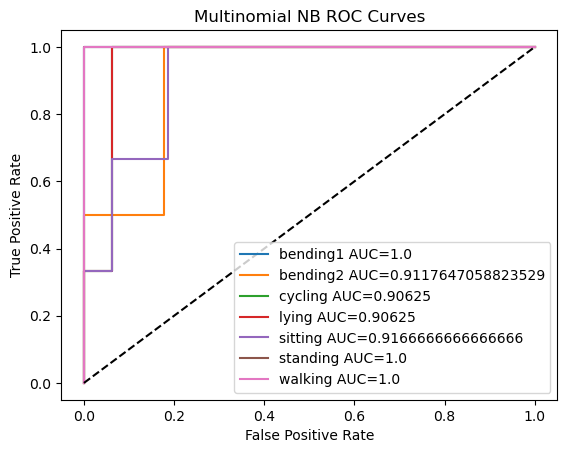

The confusion matrices for multiclass regression shows us how many times one class (in the 7 classes) is either classified correctly or misclassified


In [54]:
# Multinomial NB
scaler_mult = MinMaxScaler()
X_train_m = scaler_mult.fit_transform(X_train)
X_test_m  = scaler_mult.transform(X_test)

multnb = MultinomialNB()
multnb.fit(X_train_m, y_train)
y_pred_m = multnb.predict(X_test_m)
acc_m = accuracy_score(y_test, y_pred_m)
test_error_m = 1-acc_m
print("Multinomial Test Error: ", test_error_m)
confusionmult = confusion_matrix(y_test, y_pred_m, labels=classes)
print(confusionmult)

#ROC/AUC
y_score_m = multnb.predict_proba(X_test_m)
y_test_bin_m = label_binarize(y_test, classes=classes)

plt.figure()
for i in range(7):
    fpr, tpr, _ = roc_curve(y_test_bin_m[:, i], y_score_m[:, i])
    roc_aucc = auc(fpr, tpr)
    plt.step(fpr, tpr, label=classes[i] + " AUC=" + str(roc_aucc))

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multinomial NB ROC Curves")
plt.legend()
plt.show()

print("The confusion matrices for multiclass regression shows us how many times one class (in the 7 classes) is either classified correctly or misclassified")

Note: I tried to troubleshoot why the lines are diagonal sometimes for multinomial regression (and entirely in the gaussian NB) rather than step curves like expected but I could not find a solution. So I decided to use plt.step instead of plt.plot, as I realized it should be a step-like curve for the ROC curves. Additionally, when applying StandardScaler() to Multinomial NB, it was throwing an error, so I decided to use another scaler (MinMaxScaler()) and that seemed to work. 

### 9.3 Comparison
Compare both NB methods to the multinomial logistic regression model in terms of accuracy and behavior.

The Gaussian Naive Bayes model has a lower test error than both the multinomial NB and Multinomial Regression so in this dataset the Gaussian seems to perform better for multiclass classification. Although this answer may vary depending on the dataset size and the relative relationships between them. 

## 10. Summary of Results

### Binary classification
The best-performing model is L1-regularized logistic regression, which achieved high AUC and stable feature selection.

### Multiclass classification
L1-penalized multinomial logistic regression provided the strongest results across all seven activity classes.

### Observations
- Time-series segmentation improves model capacity  
- Regularization stabilizes logistic regression under near-separable conditions  
- Class imbalance must be handled carefully to avoid biased evaluation  


## References 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

https://www.google.com/search?q=how+to+see+which+features+are+selected+in+logistic+regression+after+using+rfe&rlz=1C5CHFA_enUS969US982&oq=how+to+see+which+features+are+selected+in+logistic+regression+after+using+rfe+&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCTEzMDEyajBqOagCBrACAfEFZOpmFkBqAIE&sourceid=chrome&ie=UTF-8

https://imbalanced-learn.org/stable/under_sampling.html#random-under-sampling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html

https://jupyterbook.org/en/stable/content/math.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://stackoverflow.com/questions/25497398/how-to-construct-the-confusion-matrix-for-a-multi-class-variable

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html